# Parsing Build Request from Google Sheet

**Inputs**

* Google spreadsheetId
* Sheetname
* Token path
* `credentials.json` (required from Google)
* backbone sequences
* *additional modifications to sequences?*

**Outputs**

* `output_plasmids/*.gb`

In [182]:

# inputs
spreadsheet_id = '1aDZv-A8JRGZbtVFugOsB6w-001pni8DDIoj1IXdRcMQ'
sheetname = 'Design'

token_path = 'token.pickle'
creds_path = 'credentials.json'

## Get build request data from GoogleSheets

In [183]:
from __future__ import print_function
import pickle
import os.path
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request


SCOPES = ['https://www.googleapis.com/auth/spreadsheets.readonly']


def get_creds():
    creds = None

    if os.path.exists(token_path):
        with open(token_path, 'rb') as token:
            creds = pickle.load(token)

    # If there are no (valid) credentials available, let the user log in.
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                creds_path, SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open(token_path, 'wb') as token:
            pickle.dump(creds, token)
    return creds

creds = get_creds()
service = build('sheets', 'v4', credentials=creds)

In [184]:
# execute the request
request = service.spreadsheets().values().get(spreadsheetId=spreadsheet_id, range=sheetname)
data = request.execute()

In [ ]:
# parse the values
from aqbt.build_request import parse_parts, CellValue

values = CellValue.to_cell_values(data['values'])

parts = parse_parts(values)

name_to_part_dict = {p['name'].lower().strip(): p for p in parts}

def get_part(name):
    return name_to_part_dict[name.lower().strip()]



In [ ]:
assert len(name_to_part_dict) == len(parts)

composite_parts = [p for p in parts if p['partType'] == 'composite part']

strains = [s for s in composite_parts if 'strain' in s['name'].lower()]
plasmids = [s for s in composite_parts if 'strain' not in s['name'].lower()]

for s in strains:
    for p in s['parts']:
        part = name_to_part_dict[p.lower()]
        if part['partType'] == 'basic part':
            raise Exception("{} is not a composite part".format(p))

## BioLinter

In [186]:
import re
import bisect
from pprint import pformat

class BioLinter(object):
    
    PROMOTER = ['promoter', 'http://identifiers.org/so/SO:0000167']
    TERMINATOR = ['terminator', 'http://identifiers.org/so/SO:0000141']
    
    def find_features(self, record, feature_types):
        features = []
        for f in record.features:
            if f.type.strip().lower() in [t.lower() for t in feature_types]:
                features.append(f)
        return features
    
    def find_promoter(self, record):
        return self.find_features(record, self.PROMOTER)
    
    def find_terminator(self, record):
        return self.find_features(record, self.TERMINATOR)
    
    def find_seq(self, record, pattern, ignore_case=False):
        if ignore_case:
            list(re.finditer(pattern, str(record.seq), re.IGNORECASE))
        return list(re.finditer(pattern, str(record.seq)))
    
    def find_start(self, record):
        return self.find_seq(record, 'ATG', ignore_case=True)
    
    def find_stop(self, record):
        return self.find_seq(record, 'TAG|TAA|TGA', ignore_case=True)
    
    @staticmethod
    def _by_frame(matches):
        frames = {
            0: [],
            1: [],
            2: []
        }
        for match in matches:
            frame = match.span()[0] % 3
            frames[frame].append((match.span()[0], match))
            
        for v in frames.values():
            v.sort()
        return frames
    
    def find_cds(self, record, i, j):
        region = record[i:j]
        starts = self.find_start(region)
        ends = self.find_stop(region)
        start_frames = self._by_frame(starts)
        end_frames = self._by_frame(ends)
            
        cds = []
        for f in [0, 1, 2]:
            _starts = start_frames[f]
            _ends = end_frames[f]
                
            for start in _starts:
                end_index = bisect.bisect_right([_x[0] for _x in _ends], start[0])
                if not end_index == len(_ends):
                    cds.append((f, start[0]+i, _ends[end_index][0]+i))
        return cds
    
    
    
    def validate_cds(self, record, threshold=30):
        errors = []
        promoters = self.find_promoter(record)
        terminators = self.find_terminator(record)
        if not promoters:
            errors.append('Error: {} has no promoters'.format(record.name))
        if not terminators:
            errors.append('Error: {} has no terminators'.format(record.name))
            
        if len(promoters) > 1:
            errors.append("Error: {} more than one promoter: {}".format(record.name, promoters))
        if len(terminators) > 1:
            errors.append("Error: {} more than one terminator: {}".format(record.name, terminators))
        if not errors:
            start_index = promoters[0].location.end
            end_index = terminators[0].location.start
            cds_list = self.find_cds(record, start_index, end_index)
            
            valid_cds = []
            for cds in cds_list:
                near_promoter = False
                near_terminator = False
                within_bp = threshold
                if start_index <= cds[1] and cds[1] <= start_index + within_bp:
                    near_promoter = True
                if end_index - within_bp <= cds[2] and cds[2] <= end_index:
                    near_terminator = True
                if (near_promoter and near_terminator):
                    valid_cds.append(cds)
            if not valid_cds:
                msg = "Error: No valid CDS"
                msg += "\n\tRecord: {}".format(record.name)
                msg += "\n\tPromoter End: {}".format(start_index)
                msg += "\n\tTerminator Start: {}".format(end_index)
                msg += "\n\tCDS List: {}".format((cds_list))
                errors.append(msg)
                
                    
            
        return errors
    
    def errors(self, record):
        errors = []
        errors += self.validate_cds(record)
        return errors

    def lint(self, records):
        assert isinstance(records, list)
        for record in records:
            
            errs = self.errors(record)
            if errs:
                for err in errs:
                    print(err)
                print()
                
                
linter = BioLinter()


## Export

In [188]:
from aqbt import biopython

In [189]:
import operator
import functools

def build_sequence(part):
    """Build a SeqRecord from a part"""
    if part['partType'] == 'basic part':
        seq_str = part['sequence']
        seq = biopython.new_sequence(seq_str, name=part['name'], auto_annotate=True, cyclic=False, annotation_type=part['roles'][0])
        return seq
    elif part['partType'] == 'composite part':
        subparts = [get_part(name) for name in part['parts']]
        subsequences = [build_sequence(part) for part in subparts]
        seq = functools.reduce(operator.add, subsequences)
        biopython.annotate(seq, name=part['name'])
        return seq
    else:
        raise Exception("'{}' is not a recognized partType".format(part['partType']))
    
def add_backbone(backbone, insert, jxn1, jxn2):
    seq = insert + jxn2 + backbone + jxn1
    seq.name = backbone.name + '_' + insert.name
    return seq

pp2 = biopython.new_sequence('CCTTAACCAGATTCGAAAAGCGGC', name='PP2', auto_annotate=True)
ts = biopython.new_sequence('TGATACCGTCGACCTCGAGTCA', name='TS', auto_annotate=True)
    
build_sequence(strains[0])

from Bio import SeqIO

with open('pmod8_backbone.gb', 'r') as f:
    bb1 = SeqIO.read(f, format='genbank')
    
with open('pmod6_backbone.gb', 'r') as f:
    bb2 = SeqIO.read(f, format='genbank')
    
with open('pmod-ho-kanmx.gb', 'r') as f:
    bb3 = SeqIO.read(f, format='genbank')
backbones = [bb1, bb2, bb3]

complete_plasmids = {}

from Bio.Alphabet import generic_dna

for strain in strains:
    for i, plasmid_name in enumerate(strain['parts']):
        if plasmid_name not in complete_plasmids:
            insert_seq = build_sequence(get_part(plasmid_name))
            insert_seq.name = '{}'.format(plasmid_name)
            linter.lint([insert_seq])
            backbone = backbones[i]
            plasmid_seq = add_backbone(backbone=backbone, insert=insert_seq, jxn1=pp2, jxn2=ts)
            plasmid_seq.seq.alphabet = generic_dna
            complete_plasmids[plasmid_name] = biopython.make_cyclic([plasmid_seq])
       
from os.path import join



for pname, p in complete_plasmids.items():
    path = join('output_plasmids', '{}.gb'.format(p.name))
    with open(path, 'w') as f:
        SeqIO.write(p, f, format='genbank')

Error: No valid CDS
	Record: Input_node_doxy_anac102
	Promoter End: 477
	Terminator Start: 2004
	CDS List: [(0, 477, 1620), (0, 813, 1620), (0, 975, 1620), (0, 1188, 1620), (0, 1299, 1620), (0, 1344, 1620), (0, 1482, 1620), (0, 1854, 1863), (0, 1866, 1887), (0, 1983, 2001), (1, 1210, 1249), (1, 1258, 1345), (1, 1468, 1594), (1, 1471, 1594), (1, 1510, 1594), (2, 896, 914), (2, 959, 989), (2, 998, 1016), (2, 1364, 1403), (2, 1433, 1439), (2, 1928, 1949), (2, 1955, 1973)]

Error: No valid CDS
	Record: Input_node_be_anac102
	Promoter End: 316
	Terminator Start: 1843
	CDS List: [(0, 316, 1459), (0, 652, 1459), (0, 814, 1459), (0, 1027, 1459), (0, 1138, 1459), (0, 1183, 1459), (0, 1321, 1459), (0, 1693, 1702), (0, 1705, 1726), (0, 1822, 1840), (1, 1049, 1088), (1, 1097, 1184), (1, 1307, 1433), (1, 1310, 1433), (1, 1349, 1433), (2, 735, 753), (2, 798, 828), (2, 837, 855), (2, 1203, 1242), (2, 1272, 1278), (2, 1767, 1788), (2, 1794, 1812)]



In [169]:
linter.lint(list(complete_plasmids.values()))

Error: strong_exp_med_ad_tet more than one promoter: [SeqFeature(FeatureLocation(ExactPosition(0), ExactPosition(680), strand=1), type='Promoter'), SeqFeature(FeatureLocation(ExactPosition(5387), ExactPosition(5699), strand=1), type='promoter')]
Error: strong_exp_med_ad_tet more than one terminator: [SeqFeature(FeatureLocation(ExactPosition(1427), ExactPosition(1652), strand=1), type='Terminator'), SeqFeature(FeatureLocation(ExactPosition(6359), ExactPosition(6541), strand=1), type='terminator'), SeqFeature(FeatureLocation(ExactPosition(1696), ExactPosition(1936), strand=1), type='terminator')]

Error: Input_node_doxy_ataf1 more than one promoter: [SeqFeature(FeatureLocation(ExactPosition(252), ExactPosition(477), strand=1), type='Promoter'), SeqFeature(FeatureLocation(ExactPosition(5018), ExactPosition(5266), strand=-1), type='promoter'), SeqFeature(FeatureLocation(ExactPosition(4665), ExactPosition(4694), strand=1), type='promoter'), SeqFeature(FeatureLocation(ExactPosition(2602), Ex

In [103]:
mkdir 'output_plasmids'

In [69]:
strain = strains[0]

for pname in strain['parts']:
    part = get_part(pname)
    if not

## Preprocessing

In [53]:
name_to_part_dict['Input_node_doxy_jub1']

KeyError: 'Input_node_doxy_jub1'

# Errors

White space in between section headings???

## Submit Plasmids

In [11]:
markers = ['URA', 'HIS', 'TRP']

backbones = []

plasmids[1]

{'name': 'medium_exp_med_ad_tet',
 'collection': 'Inducer_receptors',
 'partType': 'composite part',
 'description': 'Tet protein is driven by a medium promoter and has a medium strength activation domain',
 'parts': ['pRPL18B']}

## Build dependency graph

In [ ]:
import networkx as nx
from typing import *

name_to_part_dict = {p['name']: p for p in parts}
assert len(name_to_part_dict) == len(parts)

def get_dependency_graph(parts: List[dict]) -> nx.DiGraph:

    # create dependency graph
    g = nx.DiGraph()

    for p in parts:
        g.add_node(p['name'], part=p)

    for p in parts:
        if p['partType'] == 'composite part':
            for p2 in p['parts']:
                g.add_edge(p2, p['name'])
    g.name = 'Dependency Graph'
    return g

g = get_dependency_graph(parts)

print(nx.info(g))
print()

plasmid_to_strains = {}
for p in plasmids:
    successors = list(g.successors(p['name']))
    plasmid_to_strains[p['name']] = successors
    
d = sorted(list(plasmid_to_strains.items()), key=lambda x: len(x[1]), reverse=True)

print([len(_d[1]) for _d in d])

Name: Dependency Graph
Type: DiGraph
Number of nodes: 211
Number of edges: 577
Average in degree:   2.7346
Average out degree:   2.7346

[18, 18, 18, 18, 18, 18, 18, 18, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]


## Build MST graph

In [148]:
list(combinations([1, 2], r=0))

[()]

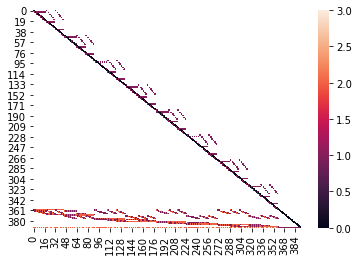

144


In [ ]:
from itertools import combinations

strain = strains[-1]

def get_intermediates(parts: List[str]):
    x = []
    for intermediate in combinations(parts, r=len(parts)-1):
        x.append(tuple(list(sorted(intermediate))))
    return [{
        'name': _x,
        'parts': _x
    } for _x in x]


def add_intermediates(strains, g):
    remaining = []
    
    intermediate_strains = {}
    for s1 in strains:
        intermediates = get_intermediates(s1['parts'])
        for s2 in intermediates:
            if len(s2['parts']) > 0:
                intermediate_strains[s2['name']] = s2
            g.add_edge(s2['name'], s1['name'])
    remaining = list(intermediate_strains.values())
    if remaining:
        add_intermediates(remaining, g)
    return

mst_graph = nx.DiGraph()
add_intermediates(strains, mst_graph)
for n in strains:
    mst_graph.nodes[n['name']]['target'] = True
# remaining

s = sorted(strains, key=lambda x: len(x['parts']))
s[-1]

from networkx.algorithms.approximation import steiner_tree

# solution = steiner_tree(mst_graph, terminal_nodes=[s['name'] for s in strains])

# print(solution.number_of_nodes())

%matplotlib inline
nx.draw(solution, node_size=2)

terminal_nodes = [s['name'] for s in strains]

mst_graph_r = mst_graph.reverse()
g = mst_graph_r.subgraph(terminal_nodes)
print(len(terminal_nodes))
g.number_of_edges()
# for s in strain_names[:5]:
#     print(s)
#     s2_list = list(solution.neighbors(s))
#     print(s2_list)
# mst_graph.number_of_edges()
# add_intermediates(remaining, mst_graph)
# add_intermediates(remaining.values(), mst_graph)
# mst_graph.number_of_edges()

# nx.draw(mst_graph)
# intermediates = []

# for strain in strains:
#     for intermediate in combinations(strain['parts'], r=2):
        
# strain['parts']
# from networkx.algorithms.tree.branchings import minimum_spanning_arborescence

# minimum_spanning_arborescence(mst_graph)
%matplotlib inline
w = nx.floyd_warshall_numpy(mst_graph)
sns.heatmap(w, vmin=0, vmax=3)


In [249]:
transitive_closure = nx.DiGraph()
for i, j in permutations(list(range(len(nodelist))), r=2):
    n1 = nodelist[i]
    n2 = nodelist[j]
    w = W[i, j]
    if not np.isinf(w):
        transitive_closure.add_edge(n1, n2, weight=w)
        
print(nx.info(transitive_closure))

solution = nx.minimum_spanning_arborescence(transitive_closure)

print(nx.info(solution))

Name: 
Type: DiGraph
Number of nodes: 392
Number of edges: 1296
Average in degree:   3.3061
Average out degree:   3.3061


NetworkXException: No minimum spanning arborescence in G.

Name: 
Type: DiGraph
Number of nodes: 24
Number of edges: 23
Average in degree:   0.9583
Average out degree:   0.9583
Name: 
Type: DiGraph
Number of nodes: 24
Number of edges: 44
Average in degree:   1.8333
Average out degree:   1.8333
SM_doxy_ataf1_2bs_stable_gfp_strain


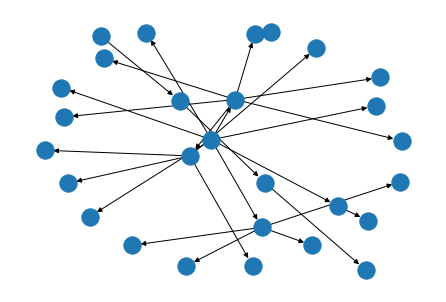

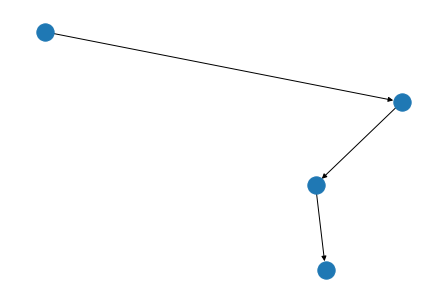

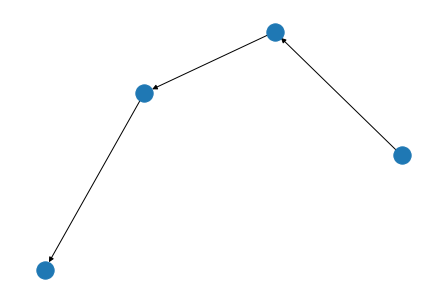

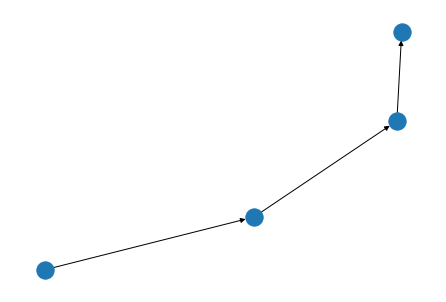

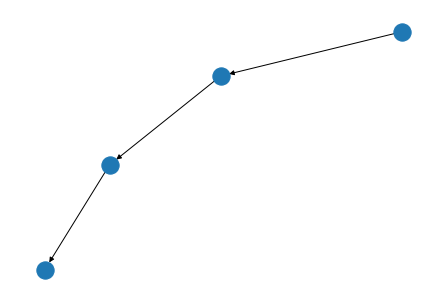

In [266]:
import seaborn as sns
from itertools import permutations
import numpy as np
import pylab as plt

mst_graph = nx.DiGraph()
add_intermediates(strains[:5], mst_graph)
for n in strains[:5]:
    mst_graph.nodes[n['name']]['target'] = True

g = nx.maximum_branching(mst_graph)


# tree = nx.bfs_tree(g.reverse(), strain_names[0])
# nx.draw(tree)

# tree = nx.bfs_tree(g.reverse(), list(tree.nodes())[1])
# nx.draw(tree)

print(nx.info(g))

print(nx.info(mst_graph))
nx.draw(g)
print(strain_names[0])
list(g.predecessors(strain_names[0]))

for s in strains[:5]:
    strain_name = s['name']
    tree = nx.bfs_tree(g.reverse(), strain_name)
    nx.draw(tree)
    plt.show()
# nodelist = list(mst_graph.nodes)

# W = nx.floyd_warshall_numpy(mst_graph, nodelist=nodelist)

# g = nx.transitive_closure(mst_graph)

# # for i, j in permutations(list(range(len(nodelist))), r=2):
# #     n1 = nodelist[i]
# #     n2 = nodelist[j]
# #     w = W[j, i]
# #     print(w)
# #     if not np.isnan(w):
# #         g.edges[n1][n2]['weight'] = w
# # closure = nx.transitive_closure(mst_graph)
# # nx.floyd_warshall_numpy?
# # edges = {}
# # for n1, n2 in g.edges:
# #     if n1 not in edges:
# #         edges[n1] = {n2: {}}
# # edges

# g = nx.DiGraph()
# for i, j in permutations(list(range(len(nodelist))), r=2):
#     n1 = nodelist[i]
#     n2 = nodelist[j]
#     w = W[i, j]
#     if not np.isinf(w):
#         g.add_edge(n1, n2, weight=w)

Name: 
Type: DiGraph
Number of nodes: 10
Number of edges: 9
Average in degree:   0.9000
Average out degree:   0.9000


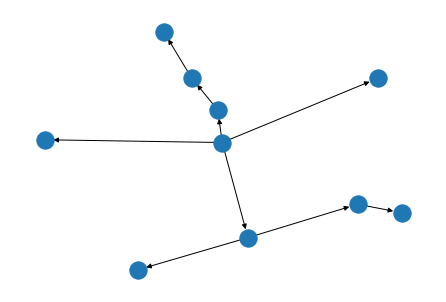

In [278]:
g = nx.DiGraph()

g.add_edge(-1, 1)
g.add_edge(-1, 2)
g.add_edge(-1, 3)
g.add_edge(-1, 4)

g.add_edge(4, (1,4))
g.add_edge(1, (1,4))
g.add_edge(1, (1,2))
g.add_edge(2, (1,2))
g.add_edge(2, (2,3))
g.add_edge(3, (2,3))
g.add_edge((1,2), (1,2,3))
g.add_edge((2,3), (1,2,3))
g.add_edge((2,3), (2,3,4))

tree = nx.minimum_spanning_arborescence(g)
print(nx.info(tree))
nx.draw(tree)

In [163]:
# transitive closure
g = nx.DiGraph()
for i, j in permutations(list(range(len(nodelist))), r=2):
    n1 = nodelist[i]
    n2 = nodelist[j]
    w = W[i, j]
    if not np.isinf(w):
        g.add_edge(n1, n2, weight=w)
   
# subgraph
# sg = g.subgraph(strain_names)

from networkx.algorithms.tree.branchings import maximum_spanning_arborescence

tree = maximum_spanning_arborescence(g)
nx.draw(tree, node_size=5)
# nx.draw(g, node_size=5)

NetworkXException: No maximum spanning arborescence in G.

In [ ]:
def get_bipartite_graph(parts: List[dict]) -> nx.DiGraph:

    # create dependency graph
    g = nx.DiGraph()

    for p in parts:
        if p['partType'] == 'composite part':
            g.add_node(p['name'], part=p)

    for p in parts:
        if p['partType'] == 'composite part':
            for p2 in p['parts']:
                g.add_edge(p2, p['name'])
    g.name = 'Dependency Graph'
    return g

g = get_bipartite_graph(parts)
nodes = [s['name'] for s in strains]
pos = nx.bipartite_layout(g, nodes=nodes)

nx.draw(g, pos=pos)metric_closure

## Build Rules

List of rules to create junctions. Every junction needs to have at least one rule, even if it returns `None`.


In [ ]:
build_rules = []


In [ ]:
from networkx.drawing.nx_agraph import graphviz_layout


# pos=nx.spectral_layout(g)
nx.draw(g)
